# Earthquake data

#### Load Python tools

In [1]:
%load_ext lab_black

In [10]:
import pandas as pd
import geopandas as gpd

In [11]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

---

## Read data

#### Northridge quake [impact area data](https://services.arcgis.com/QJfoC7c7Z2icolha/arcgis/rest/services/impact_area1375916377789/FeatureServer/0)  from Esri

In [12]:
northridge_src = gpd.read_file(
    "https://raw.githubusercontent.com/stiles/usc/main/data/geo/impact_area.geojson"
)

<AxesSubplot:>

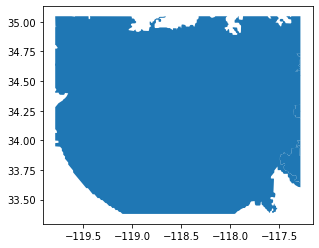

In [13]:
northridge_src.plot()

In [14]:
northridge_src.columns

Index(['OBJECTID', 'CIKR_AMTwr', 'CIKR_BrTn', 'CIKR_Dam', 'CIKR_Edu',
       'CIKR_ECC', 'CIKR_FMTwr', 'CIKR_FrSta', 'CIKR_Hzmt', 'CIKR_HCF',
       ...
       'PCI_CY_2', 'TOTHU_CY_2', 'OWNER_CY_2', 'RENTER_CY_2', 'VACANT_CY_2',
       'MEDVAL_CY_2', 'AVGVAL_CY_2', 'POP014_CY', 'POP65U_CY', 'geometry'],
      dtype='object', length=153)

In [15]:
# Esri's metadata here: https://services.arcgis.com/QJfoC7c7Z2icolha/arcgis/rest/services/impact_area1375916377789/FeatureServer/0

#### Just get the number of people, businesses and infrastructure

In [16]:
northridge_src_slim = northridge_src[
    ["GRID_CODE", "CIKR_Total", "BUS_Total", "TOTPOP_CY_2", "geometry"]
].copy()

#### Rename columns

In [17]:
northridge_src_slim.rename(
    columns={
        "GRID_CODE": "impact_code",
        "CIKR_Total": "critical_infrastructure",
        "BUS_Total": "businesses",
        "TOTPOP_CY_2": "population",
    },
    inplace=True,
)

#### Add descriptions to impact codes

In [18]:
northridge_src_slim["impact_code"] = northridge_src_slim["impact_code"].astype(str)

In [19]:
codes = {
    "4": "Shaking, no damage",
    "5": "Very light",
    "6": "Light",
    "7": "Moderate",
    "8": "Moderate/Heavy",
    "9": "Heavy",
}

In [20]:
northridge_src_slim["impact_code_desc"] = northridge_src_slim["impact_code"].map(codes)

#### Prepare for export

In [21]:
northridge_src_slim = northridge_src_slim[
    [
        "impact_code",
        "impact_code_desc",
        "critical_infrastructure",
        "businesses",
        "population",
        "geometry",
    ]
]

#### Heaviest area?

<AxesSubplot:>

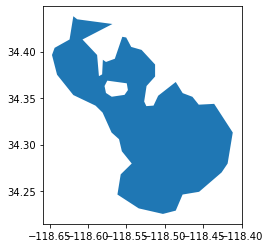

In [22]:
northridge_src_slim[northridge_src_slim["impact_code"] == "9"].plot()

#### How many people lived there? 

In [23]:
northridge_src_slim[northridge_src_slim["impact_code"] == "9"]["population"].iloc[0]

315994

---

## Historical earthquakes

#### L.A. area quakes >= 5 magnitude from USGS [earthquake catalog](https://earthquake.usgs.gov/earthquakes/search/)

In [24]:
with open("data/") as f:
    gj = geojson.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/query_mag_3.json'

In [25]:
features = gj["features"]

NameError: name 'gj' is not defined

In [ ]:
la_quakes_gdf = gpd.GeoDataFrame(features)

#### Unpack nested properties

In [ ]:
la_quakes_gdf[
    [
        "mag",
        "place",
        "time",
        "updated",
        "tz",
        "url",
        "detail",
        "felt",
        "cdi",
        "mmi",
        "alert",
        "status",
        "tsunami",
        "sig",
        "net",
        "code",
        "ids",
        "sources",
        "types",
        "nst",
        "dmin",
        "rms",
        "gap",
        "magType",
        "type",
        "title",
    ]
] = pd.json_normalize(la_quakes_gdf["properties"])

In [ ]:
la_quakes_gdf["year"] = pd.to_datetime(la_quakes_gdf["time"], unit="ms").dt.strftime(
    "%Y"
)
la_quakes_gdf["date"] = pd.to_datetime(la_quakes_gdf["time"], unit="ms").dt.strftime(
    "%Y-%m-%d"
)

In [ ]:
la_quakes_gdf.drop(
    [
        "properties",
        "type",
        "updated",
        "tz",
        "url",
        "detail",
        "status",
        "net",
        "code",
        "ids",
        "sources",
        "types",
        "alert",
    ],
    axis=1,
    inplace=True,
)

In [ ]:
la_quakes_gdf.plot()

In [ ]:
la_quakes_gdf["latitude"] = la_quakes_gdf["geometry"].x
la_quakes_gdf["longitude"] = la_quakes_gdf["geometry"].y

In [ ]:
la_quakes_gdf = la_quakes_gdf[
    [
        "id",
        "mag",
        "place",
        "year",
        "date",
        "latitude",
        "longitude",
        "title",
        "geometry",
    ]
]

In [ ]:
la_quakes_gdf.head()

---

## Export

In [ ]:
northridge_src_slim.to_file(
    "../../usc/data/geo/northridge_quake_boundaries.geojson", driver="GeoJSON"
)

In [ ]:
la_quakes_gdf.to_file(
    "../../usc/data/geo/la-area-quakes-1950-2022.geojson", driver="GeoJSON"
)